In [44]:
from scipy import stats
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.metrics import f1_score, precision_recall_curve,classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.svm import OneClassSVM
from sklearn.impute import KNNImputer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Loading the data



In [26]:
df_train = pd.read_csv('train_df.csv')
df_test = pd.read_csv('validation_df.csv')

In [27]:
df_train.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,...,0.034744,-0.007600,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,...,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,2,0.214105,0.154930,0.136640,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.047340,...,0.040884,0.375490,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,3,-0.154837,-0.127768,-0.217638,-0.284770,-0.299929,-0.270694,-0.077960,0.092036,0.076877,...,-0.286936,-0.171079,-0.036814,-0.024904,0.031400,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,4,-1.022780,-0.916376,-0.676425,-0.461445,-0.330069,-0.122690,0.178064,0.489675,0.799115,...,1.009751,1.134613,0.836030,0.479903,0.109661,-0.285553,-0.628651,-0.916376,-1.010837,-0.804544


In [28]:
df_test.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0,0.070650,0.085524,0.076847,0.085524,0.120229,0.140061,0.107834,0.048340,0.014874,...,0.018592,-0.017353,-0.049579,-0.061974,-0.022311,0.052058,0.091721,0.075608,0.045861,0.027268
1,1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
2,2,-0.056398,-0.152028,-0.058850,0.140994,0.170419,0.154480,0.270954,0.359228,0.334708,...,0.023295,-0.019617,-0.062528,-0.094405,-0.105439,-0.123830,-0.166741,-0.159385,-0.106665,-0.131186
3,3,0.030618,0.020412,0.058747,0.124712,0.155828,0.161553,0.167777,0.170515,0.165038,...,-0.073682,-0.052524,-0.023897,-0.009210,0.016429,0.058000,0.097828,0.114755,0.090360,0.054764
4,4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420


In [29]:
df_train.info()
df_test.info()

# "Unnamed: 0" sütununu sil
df_train.drop(columns=["Unnamed: 0"], inplace=True)
df_test.drop(columns=["Unnamed: 0"], inplace=True)


df_train.info()
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Columns: 61441 entries, Unnamed: 0 to 61439
dtypes: float64(61440), int64(1)
memory usage: 786.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Columns: 61441 entries, Unnamed: 0 to 61439
dtypes: float64(61440), int64(1)
memory usage: 278.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Columns: 61440 entries, 0 to 61439
dtypes: float64(61440)
memory usage: 786.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Columns: 61440 entries, 0 to 61439
dtypes: float64(61440)
memory usage: 278.4 MB


In [30]:
# Histogram çizmek için func
def show_plt(df_train):
    print(df_train.iloc[:, :10].describe())

    plt.figure(figsize=(12, 6))
    for i in range(1, 6):
        plt.subplot(2, 3, i)
        sns.histplot(df_train.iloc[:, i], kde=True, bins=30)
    plt.tight_layout()
    plt.show()


In [45]:

# Bu func eğitim ve test setlerine Principal Component Analysis uygulayacak.
def apply_PCA(train,test,n_components):
  # Standardize the data
  scaler = MinMaxScaler()
  scaled_train = scaler.fit_transform(train)

  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(scaled_train)

  pca_train = pd.DataFrame(data=principal_components)
  scaled_df_test = scaler.transform(test)
  principal_components = pca.transform(scaled_df_test)

  pca_df_test = pd.DataFrame(data=principal_components)

  return pca_train,pca_df_test



                 0            1            2            3            4  \
count  1677.000000  1677.000000  1677.000000  1677.000000  1677.000000   
mean     -0.000664    -0.003480     0.009613     0.022475     0.035903   
std       0.883526     0.835984     0.869802     0.950403     0.943731   
min      -7.496269    -6.943695    -8.947082    -8.999418    -8.675663   
25%      -0.289418    -0.275076    -0.249610    -0.228466    -0.208194   
50%       0.010897     0.009686     0.017095     0.037735     0.036144   
75%       0.246873     0.253578     0.282030     0.355087     0.319822   
max       8.915436     6.995956     6.021115     7.587554     9.290311   

                 5            6            7            8            9  
count  1677.000000  1677.000000  1677.000000  1677.000000  1677.000000  
mean      0.052162     0.070455     0.075893     0.056307     0.034468  
std       0.820365     0.821559     0.912041     0.946185     0.869336  
min      -6.466582    -7.234588    -8.339

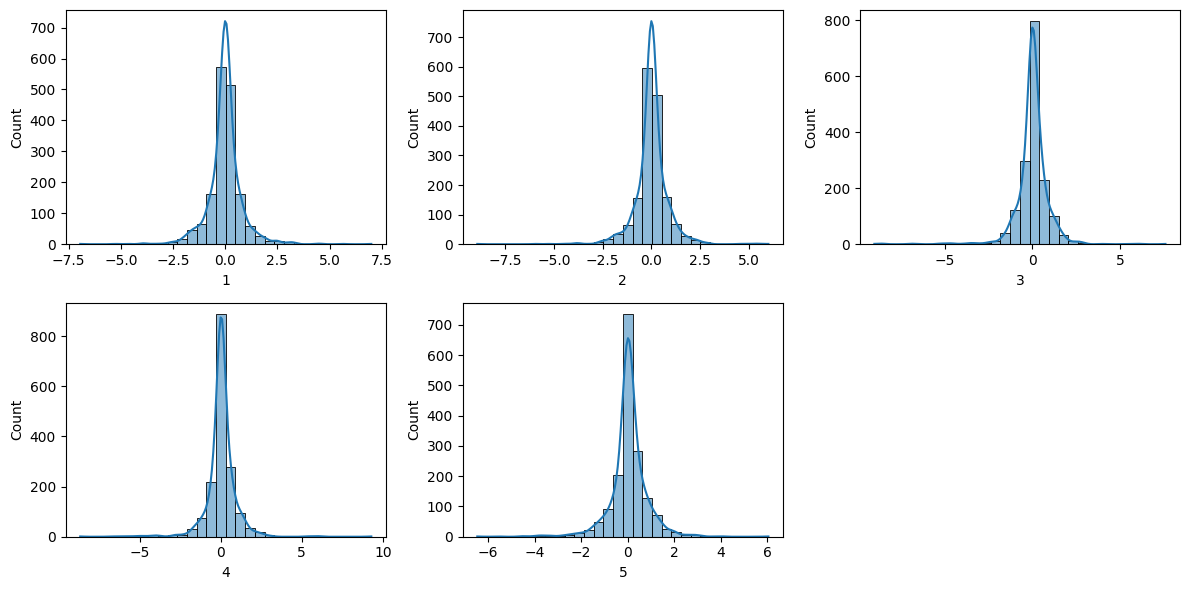

In [31]:
# Outlierlardan kurtulmadan önce
show_plt(df_train)

                 0            1            2            3            4  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean      0.003397     0.022433     0.046546     0.057736     0.054794   
std       0.361824     0.364087     0.367609     0.371529     0.375983   
min      -1.553164    -1.567793    -1.272794    -1.574047    -1.470111   
25%      -0.147900    -0.121382    -0.100552    -0.110418    -0.096798   
50%       0.016996     0.018709     0.025158     0.036214     0.035987   
75%       0.159156     0.164466     0.182395     0.207288     0.196914   
max       1.406972     1.499392     1.504855     1.508307     1.543170   

                 5            6            7            8            9  
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000  
mean      0.047805     0.040142     0.030578     0.019808     0.013176  
std       0.372563     0.366628     0.364249     0.362060     0.367740  
min      -1.558525    -1.649983    -1.729

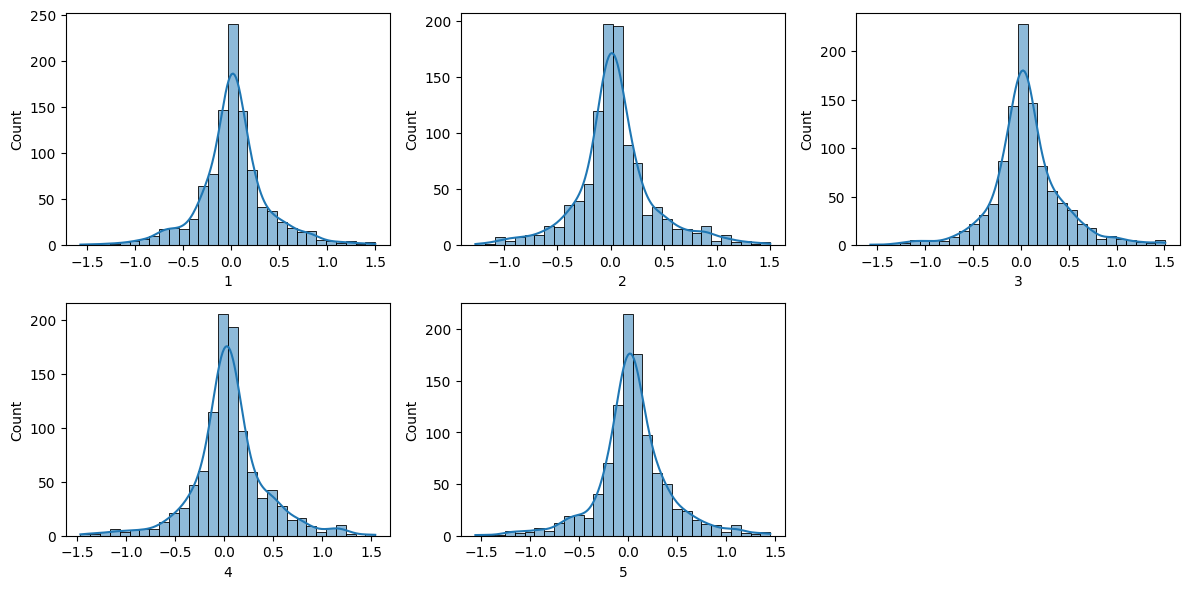

In [32]:
# Z-skoru hesaplayıp outlierlardan kurtulma

z_scores_test = np.abs(stats.zscore(df_train))
df_train = df_train[(z_scores_test < 3).all(axis=1)]

# outlierlardan kurtulduktan sonra
show_plt(df_train)


In [33]:
# Orjinal array bozulmasın diye df_train i kopyala

df_train_mean = df_train.copy()
df_test_mean = df_test.copy()
df_train_knn = df_train.copy()
df_test_knn = df_test.copy()
df_train_fbfill = df_train.copy()
df_test_fbfill = df_test.copy()

missing_values = df_train.isnull().sum()
print(missing_values)

0        0
1        0
2        0
3        0
4        0
        ..
61435    0
61436    0
61437    0
61438    0
61439    0
Length: 61440, dtype: int64


In [34]:
# Filling the missing values by the mean of data
df_train_mean.fillna(df_train_mean.mean(),inplace=True)
df_test_mean.fillna(df_test_mean.mean(),inplace=True)
missing_values = df_train_mean.isnull().sum()
print(missing_values)
print(df_train_mean.head())

0        0
1        0
2        0
3        0
4        0
        ..
61435    0
61436    0
61437    0
61438    0
61439    0
Length: 61440, dtype: int64
          0         1         2         3         4         5         6  \
0  0.041259  0.041259  0.032573  0.023887  0.029315  0.041259  0.045602   
1 -0.211722 -0.264924 -0.274696 -0.236694 -0.156349 -0.059716  0.005429   
2  0.214105  0.154930  0.136640  0.013987 -0.038733 -0.015063 -0.111894   
3 -0.154837 -0.127768 -0.217638 -0.284770 -0.299929 -0.270694 -0.077960   
4 -1.022780 -0.916376 -0.676425 -0.461445 -0.330069 -0.122690  0.178064   

          7         8         9  ...     61430     61431     61432     61433  \
0  0.038001  0.030401  0.032573  ...  0.034744 -0.007600 -0.003257  0.065145   
1  0.046687  0.153091  0.281210  ...  0.260581 -0.004343 -0.241037 -0.636252   
2 -0.104363  0.047340 -0.054871  ...  0.040884  0.375490  0.699337  0.965085   
3  0.092036  0.076877  0.154837  ... -0.286936 -0.171079 -0.036814 -0.024904   


                 0            1            2            3            4  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean      0.003397     0.022433     0.046546     0.057736     0.054794   
std       0.361824     0.364087     0.367609     0.371529     0.375983   
min      -1.553164    -1.567793    -1.272794    -1.574047    -1.470111   
25%      -0.147900    -0.121382    -0.100552    -0.110418    -0.096798   
50%       0.016996     0.018709     0.025158     0.036214     0.035987   
75%       0.159156     0.164466     0.182395     0.207288     0.196914   
max       1.406972     1.499392     1.504855     1.508307     1.543170   

                 5            6            7            8            9  
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000  
mean      0.047805     0.040142     0.030578     0.019808     0.013176  
std       0.372563     0.366628     0.364249     0.362060     0.367740  
min      -1.558525    -1.649983    -1.729

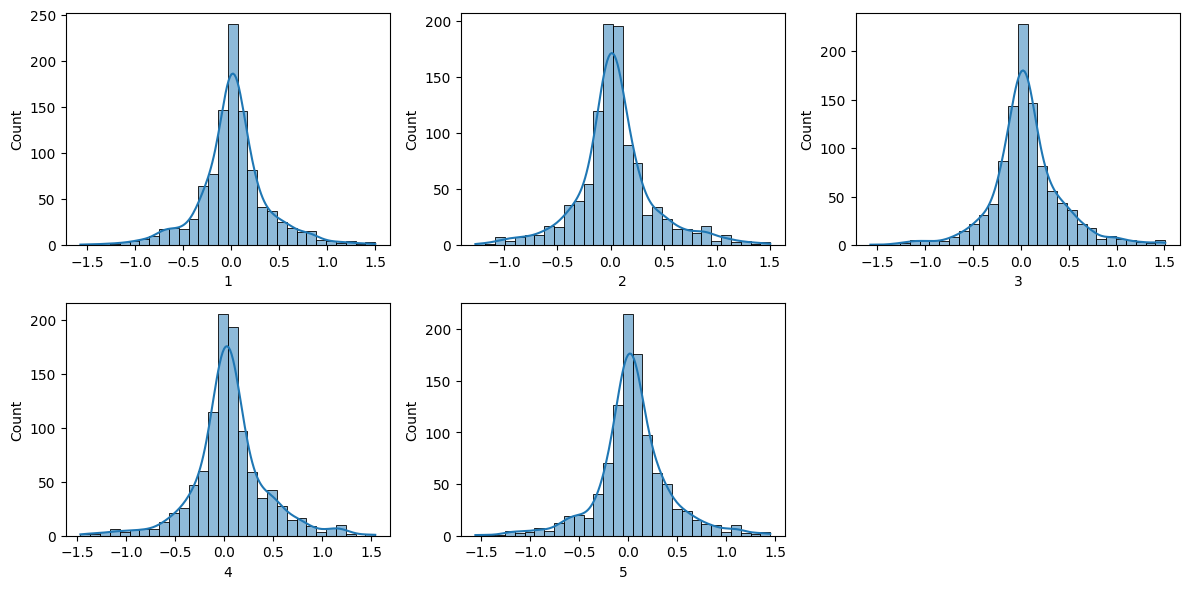

In [35]:
show_plt(df_train_mean)

In [36]:
# KNN imputation is typically applied to the entire dataset, and it considers the relationships between columns to impute missing values.

imputer = KNNImputer(n_neighbors=5)  # Adjust the number of neighbors as needed
df_train_knn = imputer.fit_transform(df_train_knn)
df_test_knn = imputer.fit_transform(df_test_knn)
df_train_knn = pd.DataFrame(df_train_knn, columns=df_train.columns)
df_test_knn = pd.DataFrame(df_test_knn, columns=df_test.columns)

df_train_knn.head()

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,0.032573,...,0.034744,-0.007600,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,0.281210,...,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,0.214105,0.154930,0.136640,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.047340,-0.054871,...,0.040884,0.375490,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,-0.154837,-0.127768,-0.217638,-0.284770,-0.299929,-0.270694,-0.077960,0.092036,0.076877,0.154837,...,-0.286936,-0.171079,-0.036814,-0.024904,0.031400,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,-1.022780,-0.916376,-0.676425,-0.461445,-0.330069,-0.122690,0.178064,0.489675,0.799115,0.931577,...,1.009751,1.134613,0.836030,0.479903,0.109661,-0.285553,-0.628651,-0.916376,-1.010837,-0.804544


                 0            1            2            3            4  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean      0.003397     0.022433     0.046546     0.057736     0.054794   
std       0.361824     0.364087     0.367609     0.371529     0.375983   
min      -1.553164    -1.567793    -1.272794    -1.574047    -1.470111   
25%      -0.147900    -0.121382    -0.100552    -0.110418    -0.096798   
50%       0.016996     0.018709     0.025158     0.036214     0.035987   
75%       0.159156     0.164466     0.182395     0.207288     0.196914   
max       1.406972     1.499392     1.504855     1.508307     1.543170   

                 5            6            7            8            9  
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000  
mean      0.047805     0.040142     0.030578     0.019808     0.013176  
std       0.372563     0.366628     0.364249     0.362060     0.367740  
min      -1.558525    -1.649983    -1.729

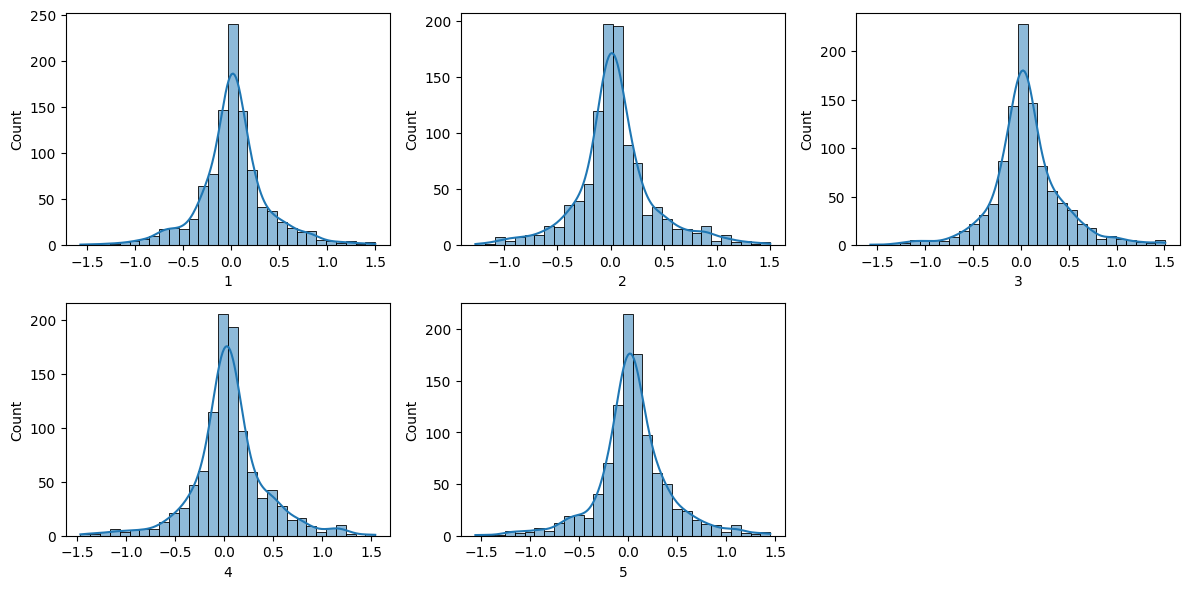

In [37]:
show_plt(df_train_knn)

In [38]:
# Applying both forward fill (ffill) and backward fill (bfill) to each column
for column in df_train.columns:
    # Apply ffill and bfill
    df_train_fbfill[column].ffill(inplace=True)
    df_train_fbfill[column].bfill(inplace=True)

# Repeat the process for test DataFrames
for column in df_test.columns:
    df_test_fbfill[column].ffill(inplace=True)
    df_test_fbfill[column].bfill(inplace=True)


# Check for remaining NaNs
print(df_train_fbfill.isnull().sum().sum())  # Total NaNs in df_train_ffill


0


                 0            1            2            3            4  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean      0.003397     0.022433     0.046546     0.057736     0.054794   
std       0.361824     0.364087     0.367609     0.371529     0.375983   
min      -1.553164    -1.567793    -1.272794    -1.574047    -1.470111   
25%      -0.147900    -0.121382    -0.100552    -0.110418    -0.096798   
50%       0.016996     0.018709     0.025158     0.036214     0.035987   
75%       0.159156     0.164466     0.182395     0.207288     0.196914   
max       1.406972     1.499392     1.504855     1.508307     1.543170   

                 5            6            7            8            9  
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000  
mean      0.047805     0.040142     0.030578     0.019808     0.013176  
std       0.372563     0.366628     0.364249     0.362060     0.367740  
min      -1.558525    -1.649983    -1.729

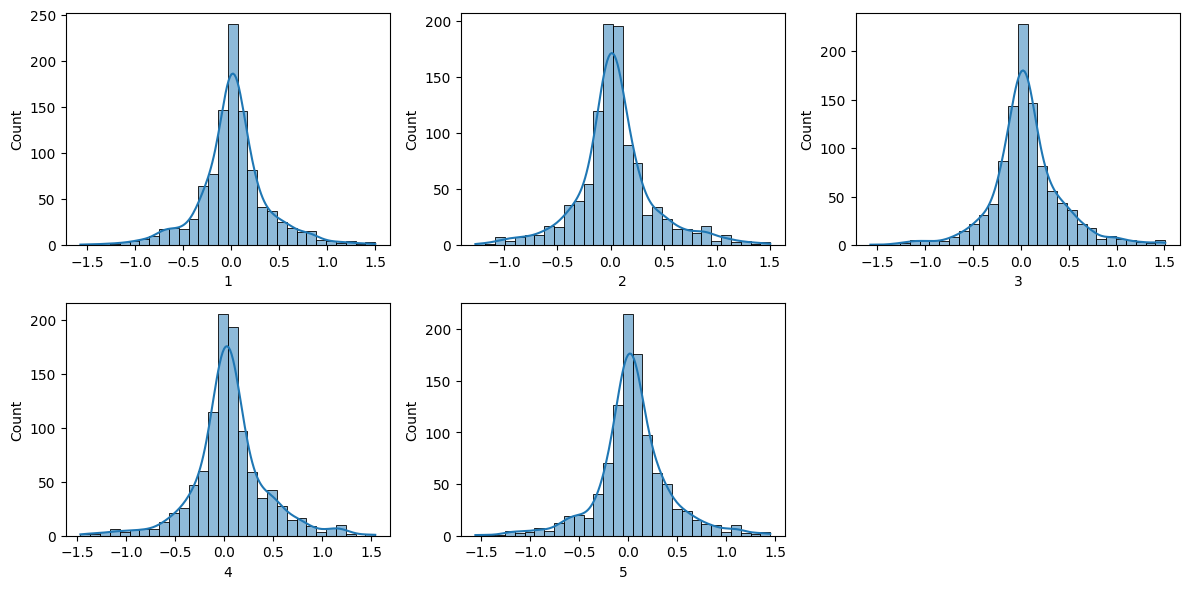

In [39]:
show_plt(df_train_fbfill)

In [ ]:
# Histogramları çiz
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_train.iloc[:,5000], bins=30, color='blue', alpha=0.7)
plt.title('İmputasyon Öncesi Histogram')
plt.xlabel('Değer')
plt.ylabel('Frekans')

plt.subplot(1, 2, 2)
plt.hist(df_train_knn.iloc[:,5000], bins=30, color='green', alpha=0.7)
plt.title('İmputasyon Sonrası Histogram')
plt.xlabel('Değer')
plt.ylabel('Frekans')

plt.tight_layout()
plt.show()

In [40]:
print(df_train.shape)
print(df_train_mean.shape)

(1038, 61440)
(1038, 61440)


In [41]:
missing_values = df_train_knn.isnull().sum()
print(missing_values)


0        0
1        0
2        0
3        0
4        0
        ..
61435    0
61436    0
61437    0
61438    0
61439    0
Length: 61440, dtype: int64


In [51]:
# Eğitim setlerine PCA uygula
n_components=0.45
pca_df_train_mean,df_test_mean_processed = apply_PCA(df_train_mean,df_test_mean,n_components)
pca_df_train_knn,df_test_knn_processed = apply_PCA(df_train_knn,df_test_knn,n_components)
pca_df_train_fbfill,df_test_fbfill_processed = apply_PCA(df_train_fbfill,df_test_fbfill,n_components)

print(pca_df_train_mean.shape)
print(pca_df_train_knn.shape)
print(pca_df_train_fbfill.shape)


(1038, 45)
(1038, 45)
(1038, 45)


In [52]:
print(pca_df_train_mean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1038 non-null   float64
 1   1       1038 non-null   float64
 2   2       1038 non-null   float64
 3   3       1038 non-null   float64
 4   4       1038 non-null   float64
 5   5       1038 non-null   float64
 6   6       1038 non-null   float64
 7   7       1038 non-null   float64
 8   8       1038 non-null   float64
 9   9       1038 non-null   float64
 10  10      1038 non-null   float64
 11  11      1038 non-null   float64
 12  12      1038 non-null   float64
 13  13      1038 non-null   float64
 14  14      1038 non-null   float64
 15  15      1038 non-null   float64
 16  16      1038 non-null   float64
 17  17      1038 non-null   float64
 18  18      1038 non-null   float64
 19  19      1038 non-null   float64
 20  20      1038 non-null   float64
 21  21      1038 non-null   float64
 22  

In [ ]:
   # Plotting the distribution of the first feature as an example
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(pca_df_train_mean.iloc[:, 0], bins=50, alpha=0.6, color='g', label='Train Feature 0')
plt.legend()
plt.title('Distribution after Scaling - Train')

plt.subplot(1, 2, 2)
plt.hist(df_test_mean_processed.iloc[:, 0], bins=50, alpha=0.6, color='b', label='Test Feature 0')
plt.legend()
plt.title('Distribution after Scaling - Test')
plt.show()

In [53]:
print(df_test_mean_processed.shape)
print(df_test_knn_processed.shape)
print(df_test_fbfill_processed.shape)

(594, 45)
(594, 45)
(594, 45)


In [49]:
import matplotlib.pyplot as plt

def show_scree_plot(df,title):
    pca = PCA()
    pca.fit(df)

    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.xlabel('Bileşen Sayısı')
    plt.ylabel('Varyans Oranı')
    plt.title(f"{title} İmputasyonları için Scree Plot")
    return plt.show()

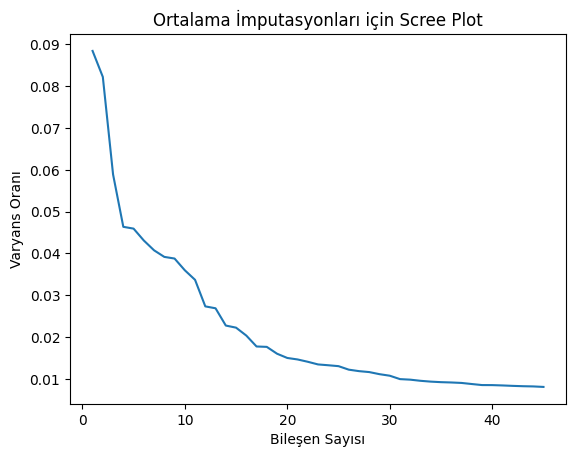

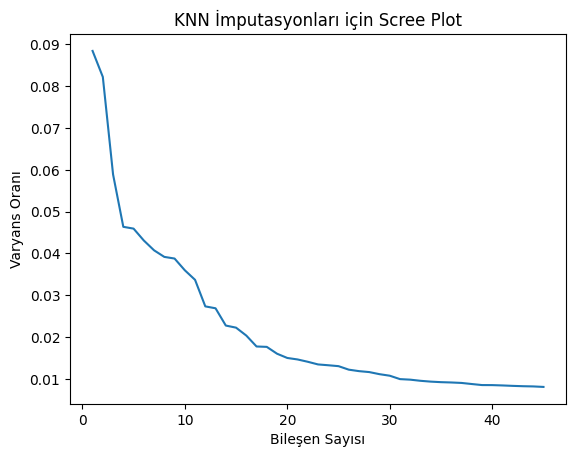

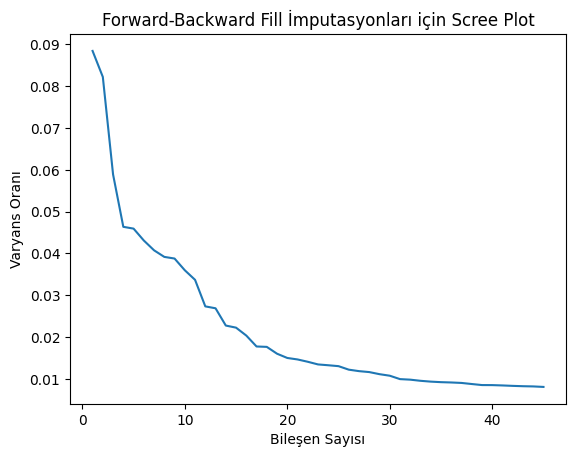

In [54]:
show_scree_plot(pca_df_train_mean,'Ortalama')
show_scree_plot(pca_df_train_knn,'KNN')
show_scree_plot(pca_df_train_fbfill,'Forward-Backward Fill')

In [56]:
df_ground_truth= pd.read_csv('dfvalid_groundtruth.csv')

true_labels = df_ground_truth['anomaly']
df_ground_truth.head()

,seqID,anomaly
0,0,0.0
1,1,1.0
2,2,0.0
3,3,0.0
4,4,1.0


In [62]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split

def isolation_forest(df_train,df_test):
    iso_forest = IsolationForest(n_estimators=200, max_samples=0.2, contamination=0.175,random_state=42)

    iso_forest.fit(df_train)

    anomalies = iso_forest.predict(df_test)
    anomalies_aligned = (anomalies == -1).astype(int)  

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, anomalies_aligned, average='binary')
    accuracy = accuracy_score(true_labels, anomalies_aligned)

    print(classification_report(true_labels, anomalies_aligned))
    print("Accuracy Score:", accuracy)

    return precision, recall, f1, accuracy, anomalies_aligned


metrics_mean=isolation_forest(pca_df_train_mean,df_test_mean_processed)
metrics_knn=isolation_forest(pca_df_train_knn,df_test_knn_processed)
metrics_fbfill=isolation_forest(pca_df_train_fbfill,df_test_fbfill_processed)

              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       297
         1.0       0.84      0.72      0.78       297

    accuracy                           0.79       594
   macro avg       0.80      0.79      0.79       594
weighted avg       0.80      0.79      0.79       594

Accuracy Score: 0.7912457912457912
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       297
         1.0       0.84      0.72      0.78       297

    accuracy                           0.79       594
   macro avg       0.80      0.79      0.79       594
weighted avg       0.80      0.79      0.79       594

Accuracy Score: 0.7912457912457912
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       297
         1.0       0.84      0.72      0.78       297

    accuracy                           0.79       594
   macro avg       0.80      0.79      0.79       594
weig

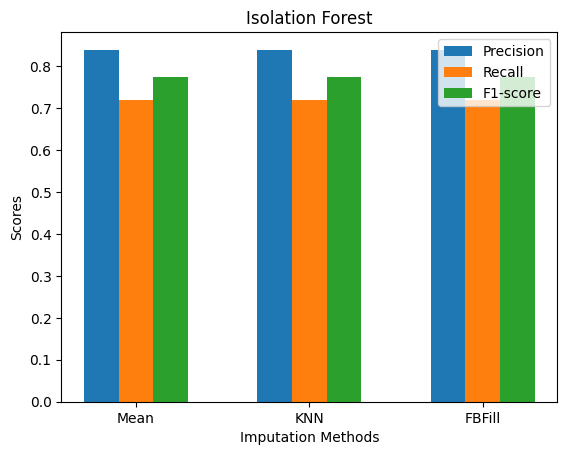

In [63]:
import numpy as np
def plot_performance_metrics(metrics_list, model_names,title):
    n_groups = len(metrics_list)
    index = np.arange(n_groups)
    bar_width = 0.2

    precisions = [metrics[0] for metrics in metrics_list]
    recalls = [metrics[1] for metrics in metrics_list]
    f1_scores = [metrics[2] for metrics in metrics_list]

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, precisions, bar_width, label='Precision')
    bar2 = ax.bar(index + bar_width, recalls, bar_width, label='Recall')
    bar3 = ax.bar(index + 2*bar_width, f1_scores, bar_width, label='F1-score')

    ax.set_xlabel('Imputation Methods')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.show()
plot_performance_metrics([metrics_mean, metrics_knn, metrics_fbfill], ['Mean', 'KNN', 'FBFill'],title='Isolation Forest')


In [84]:

def train_one_class_svm(df_train, df_test, true_labels, nu_value=0.11,tol=0.008, gamma_value='scale'):

    one_class_svm = OneClassSVM(nu=nu_value, kernel='rbf', gamma=gamma_value, tol=tol)
    one_class_svm.fit(df_train)

    # Model anomaliler için -1, normal için 1 veriyor
    svm_predictions = one_class_svm.predict(df_test)
    svm_predictions_aligned = (svm_predictions == -1).astype(int) 
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, svm_predictions_aligned, average='binary')
    accuracy = accuracy_score(true_labels, svm_predictions_aligned)

    print(classification_report(true_labels, svm_predictions_aligned))
    print("Accuracy Score:", accuracy_score(true_labels, svm_predictions_aligned))

    return precision, recall, f1, accuracy, svm_predictions_aligned

svm_metric_mean = train_one_class_svm(
    pca_df_train_mean,  
    df_test_mean_processed,  
    true_labels  
)
svm_metric_knn = train_one_class_svm(
    pca_df_train_mean,  
    df_test_mean_processed,
    true_labels 
)
svm_metric_fbfill = train_one_class_svm(
    pca_df_train_mean,  
    df_test_mean_processed, 
    true_labels 
)


              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       297
         1.0       0.89      0.89      0.89       297

    accuracy                           0.89       594
   macro avg       0.89      0.89      0.89       594
weighted avg       0.89      0.89      0.89       594

Accuracy Score: 0.8855218855218855
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       297
         1.0       0.89      0.89      0.89       297

    accuracy                           0.89       594
   macro avg       0.89      0.89      0.89       594
weighted avg       0.89      0.89      0.89       594

Accuracy Score: 0.8855218855218855
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       297
         1.0       0.89      0.89      0.89       297

    accuracy                           0.89       594
   macro avg       0.89      0.89      0.89       594
weig

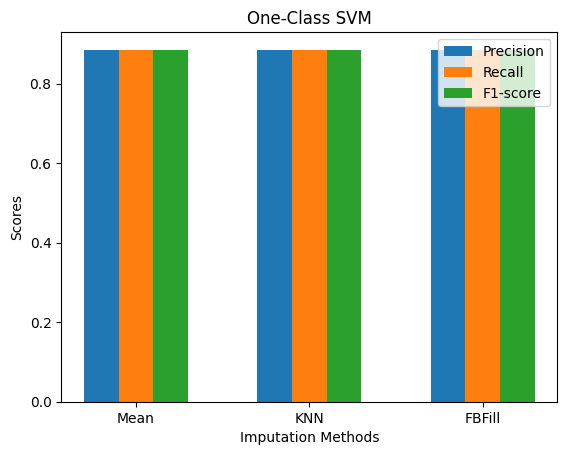

In [85]:
plot_performance_metrics([svm_metric_mean, svm_metric_knn, svm_metric_fbfill], ['Mean', 'KNN', 'FBFill'],'One-Class SVM')


In [86]:
def train_kmeans(train_data,test_data):
    # n_clusters = küme sayısı
    kmeans = KMeans(n_clusters=6,n_init=8,algorithm='lloyd')  
    kmeans.fit(train_data)

    # En yakın küme merkezine uzaklığı hesapla
    distances = kmeans.transform(train_data).min(axis=1)

    # Anomali tespiti için eşik değeri
    threshold = np.percentile(distances, 99)  

    # En yakındaki küme için uzaklığı ölç
    distances_test = kmeans.transform(test_data).min(axis=1)

    # eşik değerinden yüksek olanları işaretle
    predicted_anomalies_test = distances_test > threshold

    # Etiket değerini 0 ile 1 e değiştir
    predicted_labels_test = predicted_anomalies_test.astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels_test, average='binary')
    accuracy = accuracy_score(true_labels, predicted_labels_test)

    print(classification_report(true_labels, predicted_labels_test))
    print("Accuracy Score:", accuracy_score(true_labels, predicted_labels_test))

    return precision, recall, f1, accuracy, predicted_labels_test

kmeans_metric_mean=train_kmeans(pca_df_train_mean,df_test_mean_processed)
kmeans_metric_knn=train_kmeans(pca_df_train_knn,df_test_knn_processed)
kmeans_metric_fbfill=train_kmeans(pca_df_train_fbfill,df_test_fbfill_processed)

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       297
         1.0       1.00      0.78      0.88       297

    accuracy                           0.89       594
   macro avg       0.91      0.89      0.89       594
weighted avg       0.91      0.89      0.89       594

Accuracy Score: 0.8888888888888888
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       297
         1.0       1.00      0.78      0.88       297

    accuracy                           0.89       594
   macro avg       0.91      0.89      0.89       594
weighted avg       0.91      0.89      0.89       594

Accuracy Score: 0.8888888888888888
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       297
         1.0       1.00      0.78      0.88       297

    accuracy                           0.89       594
   macro avg       0.91      0.89      0.89       594
weig

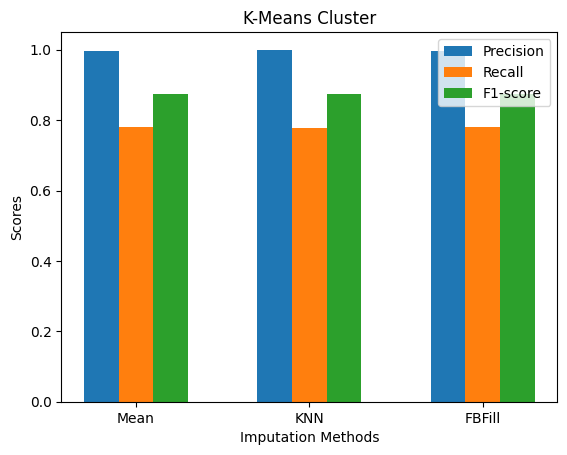

In [91]:
plot_performance_metrics([kmeans_metric_mean, kmeans_metric_knn, kmeans_metric_fbfill], ['Mean', 'KNN', 'FBFill'],title='K-Means Cluster')


In [87]:

def gmm(train_data, test_data,n_components,treshold):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')  
    gmm.fit(train_data)
    scores = gmm.score_samples(test_data)
    threshold = np.percentile(scores, treshold)  
    anomalies = scores < threshold
    predicted_labels_test = anomalies.astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels_test, average='binary')
    accuracy = accuracy_score(true_labels, predicted_labels_test)

    # Evaluate the model
    print(confusion_matrix(true_labels, predicted_labels_test))
    print(classification_report(true_labels, predicted_labels_test))
    print("Accuracy Score:", accuracy_score(true_labels, predicted_labels_test))

    return precision, recall, f1, accuracy, predicted_labels_test


gmm_mean=gmm(pca_df_train_mean,df_test_mean_processed,n_components=110,treshold=40)
gmm_knn=gmm(pca_df_train_knn,df_test_knn_processed,n_components=110,treshold=40)
gmm_fbfill=gmm(pca_df_train_fbfill,df_test_fbfill_processed,n_components=110,treshold=40)


[[288   9]
 [ 68 229]]
              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88       297
         1.0       0.96      0.77      0.86       297

    accuracy                           0.87       594
   macro avg       0.89      0.87      0.87       594
weighted avg       0.89      0.87      0.87       594

Accuracy Score: 0.8703703703703703
[[286  11]
 [ 70 227]]
              precision    recall  f1-score   support

         0.0       0.80      0.96      0.88       297
         1.0       0.95      0.76      0.85       297

    accuracy                           0.86       594
   macro avg       0.88      0.86      0.86       594
weighted avg       0.88      0.86      0.86       594

Accuracy Score: 0.8636363636363636
[[281  16]
 [ 75 222]]
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86       297
         1.0       0.93      0.75      0.83       297

    accuracy                           0.85

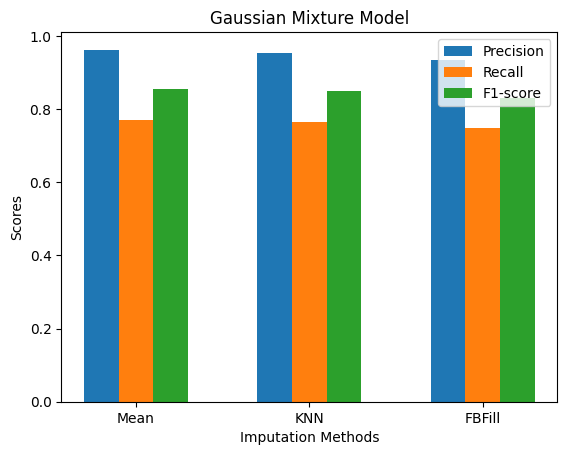

In [88]:
plot_performance_metrics([gmm_mean,gmm_knn,gmm_fbfill], ['Mean', 'KNN', 'FBFill'],title='Gaussian Mixture Model')


In [89]:
print( true_labels.info())
print(np.array(true_labels).shape)

<class 'pandas.core.series.Series'>
RangeIndex: 594 entries, 0 to 593
Series name: anomaly
Non-Null Count  Dtype  
--------------  -----  
594 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None
(594,)


(1038, 61440)
(594, 61440)
Epoch 1/50
17/17 [==============================] - 8s 244ms/step - loss: 0.4682 - val_loss: 7.7638
Epoch 2/50
17/17 [==============================] - 2s 125ms/step - loss: 0.2005 - val_loss: 8.5861
Epoch 3/50
17/17 [==============================] - 2s 122ms/step - loss: 0.2522 - val_loss: 8.3788
Epoch 4/50
17/17 [==============================] - 2s 126ms/step - loss: 0.1955 - val_loss: 7.6973
Epoch 5/50
17/17 [==============================] - 2s 125ms/step - loss: 0.0914 - val_loss: 7.5856
Epoch 6/50
17/17 [==============================] - 2s 120ms/step - loss: 0.0745 - val_loss: 7.7827
Epoch 7/50
17/17 [==============================] - 2s 121ms/step - loss: 0.0663 - val_loss: 7.8422
Epoch 8/50
17/17 [==============================] - 2s 129ms/step - loss: 0.0738 - val_loss: 7.9786
Epoch 9/50
17/17 [==============================] - 2s 126ms/step - loss: 0.0534 - val_loss: 7.8208
Epoch 10/50
17/17 [==============================] - 2s 124ms/step - loss

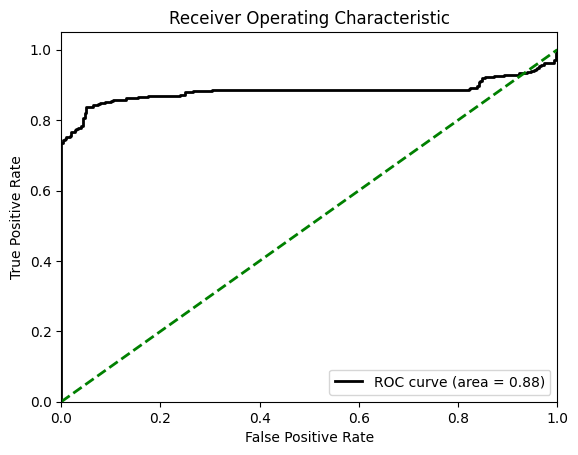

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90       297
         1.0       0.94      0.84      0.89       297

    accuracy                           0.89       594
   macro avg       0.90      0.89      0.89       594
weighted avg       0.90      0.89      0.89       594

Accuracy Score: 0.8922558922558923
(1038, 61440)
(594, 61440)
Epoch 1/50
17/17 [==============================] - 7s 223ms/step - loss: 0.4779 - val_loss: 7.5698
Epoch 2/50
17/17 [==============================] - 2s 131ms/step - loss: 0.1961 - val_loss: 8.5218
Epoch 3/50
17/17 [==============================] - 2s 134ms/step - loss: 0.2154 - val_loss: 8.1265
Epoch 4/50
17/17 [==============================] - 2s 122ms/step - loss: 0.1857 - val_loss: 7.6934
Epoch 5/50
17/17 [==============================] - 2s 121ms/step - loss: 0.0965 - val_loss: 7.9733
Epoch 6/50
17/17 [==============================] - 2s 125ms/step - loss: 0.0965 - val_loss: 8.1132
Epoch 7/50


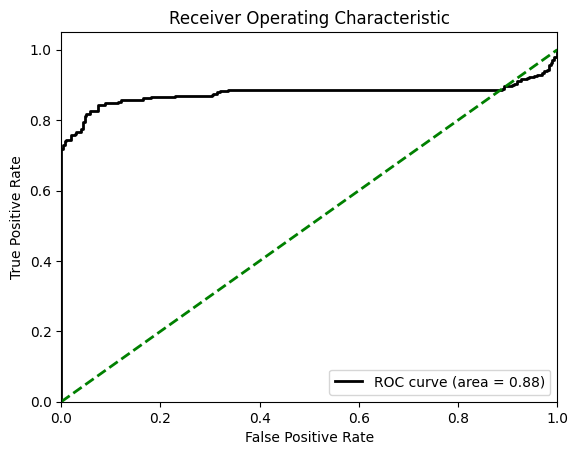

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       297
         1.0       0.92      0.84      0.88       297

    accuracy                           0.88       594
   macro avg       0.89      0.88      0.88       594
weighted avg       0.89      0.88      0.88       594

Accuracy Score: 0.8821548821548821
(1038, 61440)
(594, 61440)
Epoch 1/50
17/17 [==============================] - 9s 301ms/step - loss: 0.4802 - val_loss: 7.5957
Epoch 2/50
17/17 [==============================] - 2s 135ms/step - loss: 0.1974 - val_loss: 9.2403
Epoch 3/50
17/17 [==============================] - 2s 125ms/step - loss: 0.3490 - val_loss: 8.0547
Epoch 4/50
17/17 [==============================] - 2s 124ms/step - loss: 0.1609 - val_loss: 7.9340
Epoch 5/50
17/17 [==============================] - 2s 123ms/step - loss: 0.1037 - val_loss: 7.8713
Epoch 6/50
17/17 [==============================] - 2s 119ms/step - loss: 0.0723 - val_loss: 7.7548
Epoch 7/50


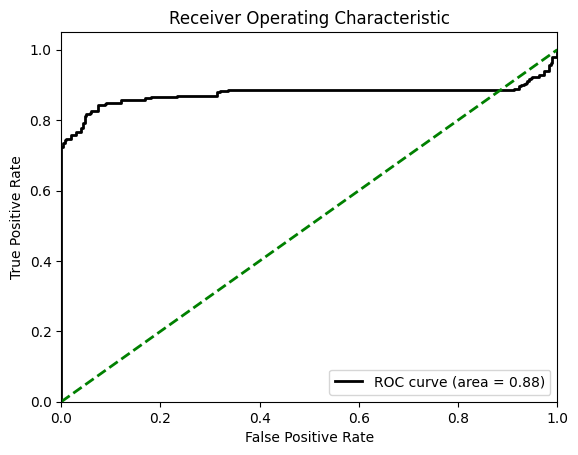

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       297
         1.0       0.92      0.84      0.88       297

    accuracy                           0.88       594
   macro avg       0.89      0.88      0.88       594
weighted avg       0.89      0.88      0.88       594

Accuracy Score: 0.8821548821548821


In [92]:

def lstm_autoencoder(train_data, test_data, true_labels, epochs, batch_size, lstm_units):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    print(train_scaled.shape)
    print(test_scaled.shape)

    # Reshape data for LSTM layer
    train_scaled = np.reshape(train_scaled, (train_scaled.shape[0], 1, train_scaled.shape[1]))
    test_scaled = np.reshape(test_scaled, (test_scaled.shape[0], 1, test_scaled.shape[1]))

    # early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, activation='sigmoid', kernel_regularizer=l2(0.003),recurrent_regularizer=l2(0.003),bias_regularizer=l2(0.003), input_shape=(train_scaled.shape[1], train_scaled.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(RepeatVector(train_scaled.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=train_scaled.shape[2]))  # Adjust the number of units

    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')

    model.fit(train_scaled, train_scaled, epochs=epochs, batch_size=batch_size,
              validation_data=(test_scaled, test_scaled), shuffle=True, callbacks=[early_stopping])

    predicted = model.predict(test_scaled)
    mse = np.mean(np.power(test_scaled - predicted, 2), axis=2).squeeze()

    precision, recall, thresholds = precision_recall_curve(true_labels, mse)
    f1_scores = 2 * recall * precision / (recall + precision)

    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]

    # Classify as anomaly if mse is greater than the threshold
    predicted_labels = mse > best_threshold

    accuracy = accuracy_score(true_labels, predicted_labels)


    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, mse)

    print('Confusion Matrix:\n', conf_matrix)
    print('\nClassification Report:\n', classification_report(true_labels, predicted_labels))
    print("ROC AUC Score:", roc_auc)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, mse)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='black', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Evaluate the model
    print(classification_report(true_labels, predicted_labels))
    print("Accuracy Score:",accuracy)
    return model, predicted_labels, mse

model, predicted_labels, mse = lstm_autoencoder(df_train_mean, df_test_mean, true_labels, epochs=50, batch_size=64, lstm_units=31)
model, predicted_labels, mse = lstm_autoencoder(df_train_knn, df_test_knn, true_labels, epochs=50, batch_size=64, lstm_units=31)
model, predicted_labels, mse = lstm_autoencoder(df_train_fbfill, df_test_fbfill, true_labels, epochs=50, batch_size=64, lstm_units=31)




Training Data: Calculate Z-scores -> Remove outliers -> Impute missing values (if any) -> Apply MinMax scaling.
Test Data: Impute missing values using the same strategy as for the training data -> Apply MinMax scaling using the parameters from the training data. Do not remove any points from the test data.